In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from tensorflow.python.keras import models
from tensorflow.python.keras import layers

In [2]:
# set up dataframes
# https://www.kaggle.com/datasets/christophercorrea/prisoners-and-crime-in-united-states
JailDeaths = pd.read_csv("datasets/all_deaths.csv", encoding='latin-1')
JailStats = pd.read_csv("datasets/all_jails.csv", encoding='latin-1')

# https://www.kaggle.com/datasets/noriuk/us-education-datasets-unification-project
Education_ByState = pd.read_csv("datasets/states_all.csv", encoding='latin-1')

# https://bjs.ojp.gov/library/publications/prisoners-2021-statistical-tables#:~:text=The%20U.S.%20prison%20population%20was,decrease%20from%202011%20(1%2C599%2C000)
p21stt01 = pd.read_csv("datasets/p21stt01.csv", encoding='latin-1')
p21stat02 = pd.read_csv("datasets/p21stat02.csv", encoding='latin-1')

Education_ByState

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,NaN,NaN,731634.0,208.0,252.0,207.0,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,NaN,NaN,122487.0,NaN,NaN,NaN,NaN
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,NaN,NaN,673477.0,215.0,265.0,209.0,NaN
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,NaN,NaN,441490.0,210.0,256.0,211.0,NaN
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,NaN,NaN,5254844.0,208.0,261.0,202.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2019_VIRGINIA,VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,247.0,287.0,224.0,262.0
1711,2019_WASHINGTON,WASHINGTON,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.0,286.0,220.0,266.0
1712,2019_WEST_VIRGINIA,WEST_VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,231.0,272.0,213.0,256.0
1713,2019_WISCONSIN,WISCONSIN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,242.0,289.0,220.0,267.0


In [3]:
# clean up states_all_extended
# set columns
Education_ByState.columns = [
    "State Key",
    "State",
    "Year",
    "Total Enrollment",
    "Total Revenue",
    "Federal Revenue",
    "State Revenue",
    "Local Revenue",
    "Total Expenditure",
    "Instruction Expenditure",
    "Support Services Expenditure",
    "Other Expenditure",
    "Capital Outlay Expenditure",
    "Total Enrollment (Pre-K)",
    "Total Enrollment (K)",
    "Total Enrollment (4)",
    "Total Enrollment (8)",
    "Total Enrollment (12)",
    "Total Enrollment (1-8)",
    "Total Enrollment (9-12)",
    "Total Enrollment (ALL)",
    "Average Math Score (4)",
    "Average Math Score (8)",
    "Average Reading Score (4)",
    "Average Reading Score (8)",
]

In [4]:
##Education Dataset Cleanup
Education_ByStateCleaned = Education_ByState.drop(['State Key'], axis = 1)
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['Year'] <= 2016]
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['Year'] >= 1992]
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['State'] != 'NATIONAL']
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['State'] != 'DODEA']

#Dropping rows that have NA values for Instruction Expenditure
Education_ByStateCleaned = Education_ByStateCleaned.dropna(subset= ['Instruction Expenditure'])



##Filtering Rows that have NAs for both enrollment estimates then filling one rows NAs with the other rows estimates. 
Education_ByStateCleaned[pd.notna(Education_ByStateCleaned['Total Enrollment']) | pd.notna(Education_ByStateCleaned['Total Enrollment (ALL)'])]
Education_ByStateCleaned['Total Enrollment'] = Education_ByStateCleaned['Total Enrollment'].fillna(Education_ByStateCleaned['Total Enrollment (ALL)'])
Education_ByStateCleaned.drop(['Total Enrollment (ALL)'], axis = 1)


#Adding Expenditure Per Student To Clean DF
Education_ByStateCleaned['Expenditure Per Student'] = Education_ByStateCleaned['Instruction Expenditure'] / Education_ByStateCleaned['Total Enrollment']

In [5]:
##Exploring The Data

##Expenditure Per Student By State
EducationExp = Education_ByStateCleaned

#Selecting appropriate columns
EducationExp = EducationExp[['State', 'Year', 'Total Enrollment', 'Instruction Expenditure','Average Math Score (4)']]

#Create Expenditure By Student
EducationExp['Expenditure Per Student'] = EducationExp['Instruction Expenditure'] / EducationExp['Total Enrollment']
EducationExpGroupby = EducationExp.groupby('State').mean()
EducationExpGroupby = EducationExpGroupby.reset_index().sort_values('Expenditure Per Student', ascending= False)

EducationExpGroupby.index = EducationExpGroupby['State'] 

C:\Users\Andrew Martinez\AppData\Local\Temp\ipykernel_16436\4240048059.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EducationExp['Expenditure Per Student'] = EducationExp['Instruction Expenditure'] / EducationExp['Total Enrollment']


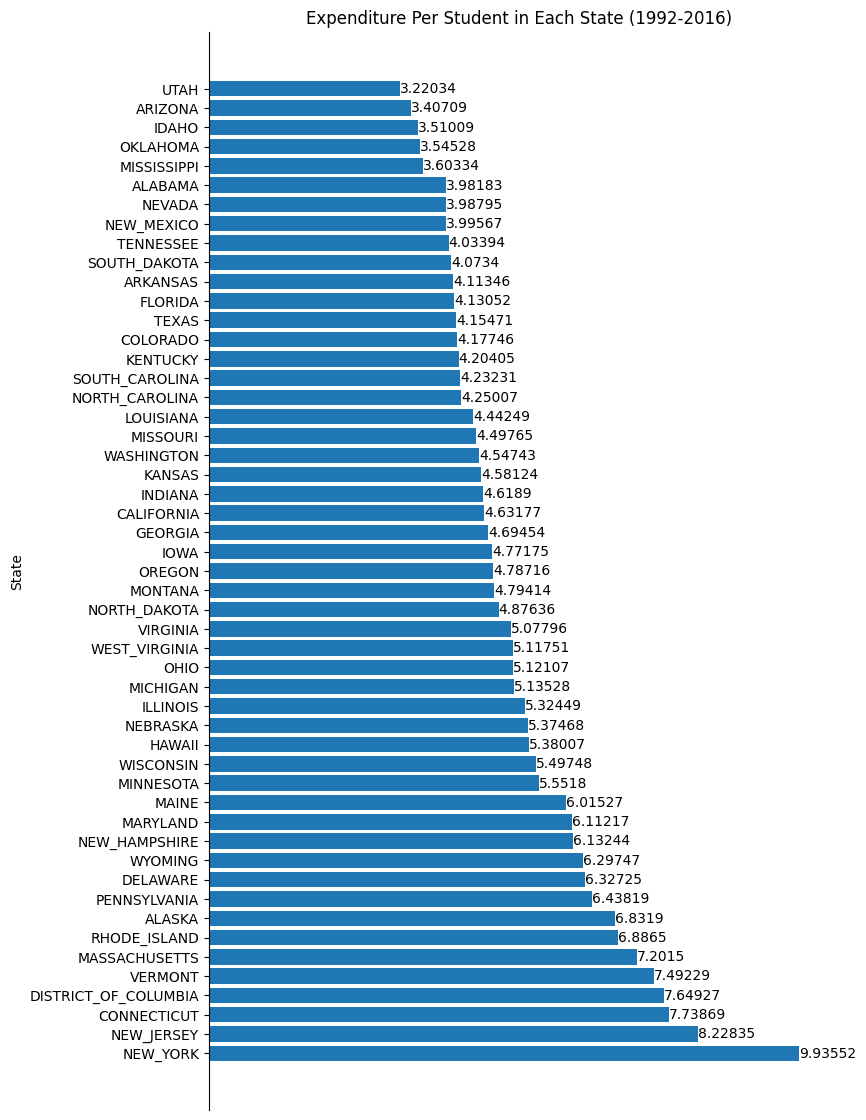

In [6]:
#Creating Groupedby DF
EducationExpGroupby = Education_ByStateCleaned.groupby('State').mean()
EducationExpGroupby = EducationExpGroupby.reset_index().sort_values('Expenditure Per Student', ascending= False)
EducationExpGroupby.index = EducationExpGroupby['State'] 

#Graphing Expenditure
fig, ax = plt.subplots(figsize=(8,14))
bars = plt.barh(EducationExpGroupby['State'],EducationExpGroupby['Expenditure Per Student'])
plt.style.use('seaborn-v0_8-notebook')
plt.ylabel("State")
ax.spines[['right','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars)

plt.title("Expenditure Per Student in Each State (1992-2016)")
plt.show()

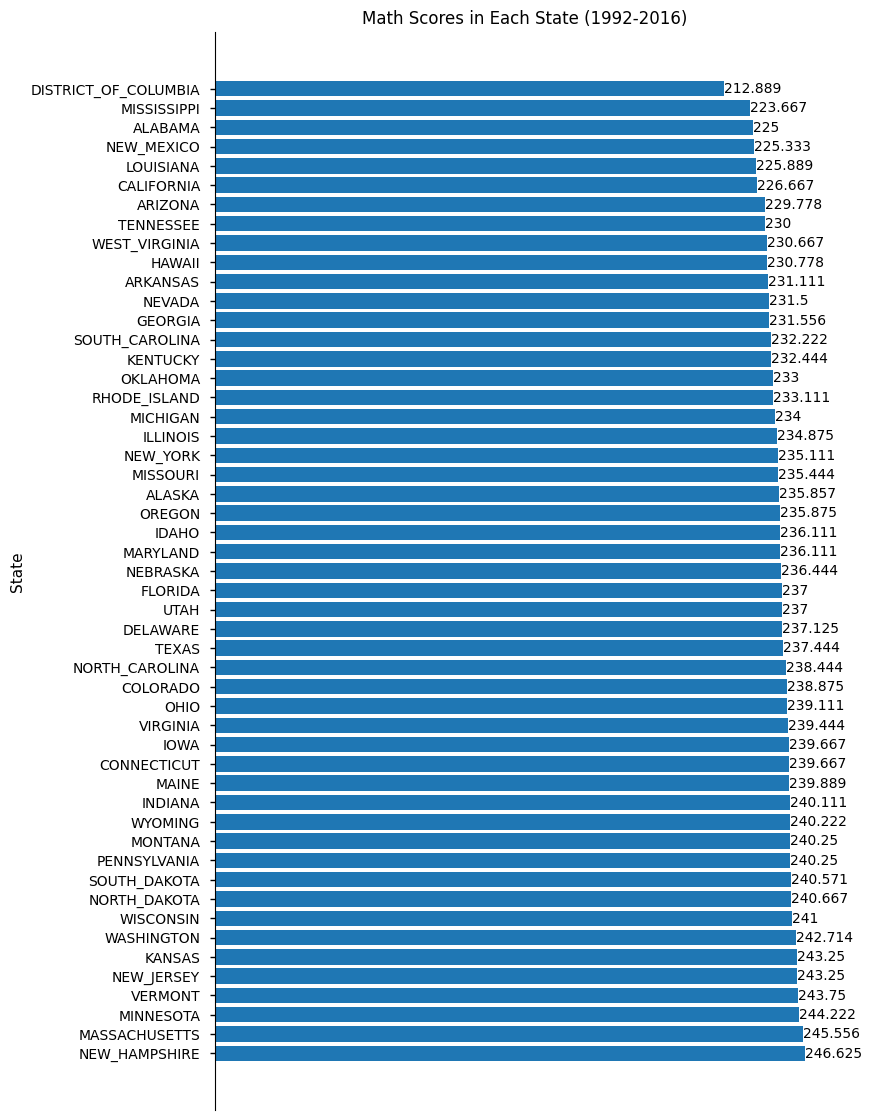

In [7]:
#Graphing Math Scores
EducationExpGroupby = EducationExpGroupby.sort_values('Average Math Score (4)', ascending= False)
fig, ax = plt.subplots(figsize=(8,14))
bars = plt.barh(EducationExpGroupby['State'],EducationExpGroupby['Average Math Score (4)'])
plt.style.use('seaborn-v0_8-notebook')
plt.ylabel("State")
ax.spines[['right','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars)

plt.title("Math Scores in Each State (1992-2016)")
plt.show()

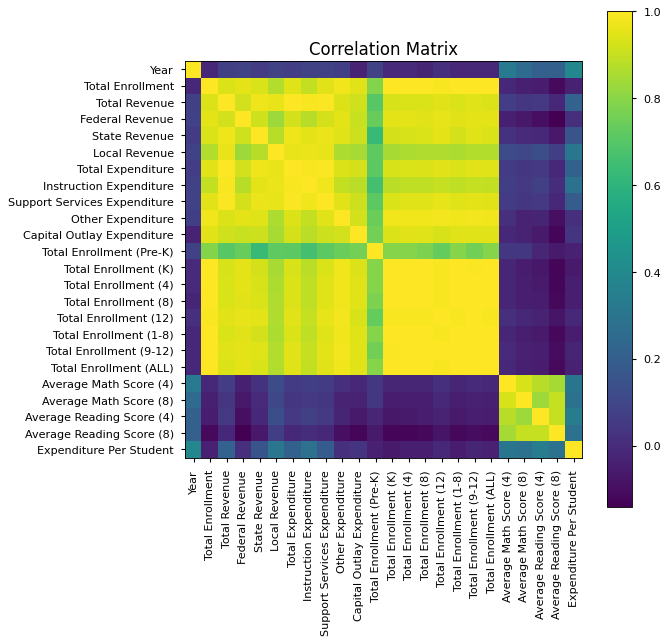

-0.13302882980495487

In [8]:
#Exploring Correlations Between Variables
CorrelationEducation = Education_ByStateCleaned

#Create Expenditure By Student
# CorrelationEducation['Expenditure Per Student'] = CorrelationEducation['Instruction Expenditure'] / CorrelationEducation['Total Enrollment']
CorrelationEducation = CorrelationEducation.drop(['State'], axis = 1)
CorrelationEducation = CorrelationEducation[pd.notna(CorrelationEducation['Average Math Score (4)']) & pd.notna(CorrelationEducation['Average Math Score (8)'])]


# Scaling data
Scaler = StandardScaler()
Scaler.fit(CorrelationEducation)
CorrelationEducation = pd.DataFrame(Scaler.transform(CorrelationEducation), 
        columns= CorrelationEducation.columns)

#Creating Correlation Matrix
corr = CorrelationEducation.dropna().corr()
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
corrMat = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.title(f'Correlation Matrix', fontsize=15)
plt.show()

#Selecting Certain Correlations From The Matrix
CorrelationEducation['Capital Outlay Expenditure'].corr(CorrelationEducation['Average Reading Score (8)'])


0.5757489631080044
0.5605971403618617
0.6635093705175705
0.6455632036118409
0.8410682817122064
0.8290280000237371
0.8335058388953117
0.8235658889786139


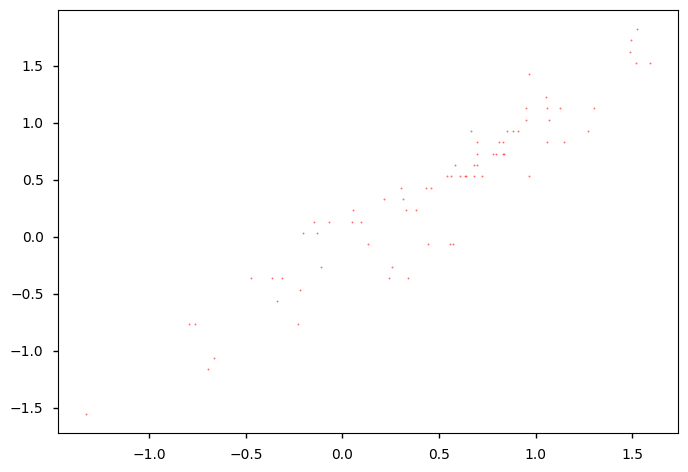

In [9]:
#Creating Linear Regression Models
import math

#Model1
Model1Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year']]
Model1Data = Model1Data[pd.notna(Model1Data['Average Math Score (4)']) & pd.notna(Model1Data['Average Math Score (8)']) 
                                        & pd.notna(Model1Data['Expenditure Per Student']) & pd.notna(Model1Data['Year'])]
TestingFloor = math.floor(len(Model1Data) * .8)
Model1DataTraining = Model1Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year']].iloc[0:TestingFloor]
Model1DataTesting = Model1Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year']].iloc[TestingFloor:]


model = LinearRegression(fit_intercept= True)
XTraining = Model1DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year']]
YTraining = Model1DataTraining['Average Math Score (8)']
XTesting = Model1DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year']]
YTesting = Model1DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
r2_score =metrics.r2_score(ModelPredictions, YTesting)
print(r2_score)
Adj_r2 = 1 - (1-r2_score) * (len(YTesting)-1)/(len(YTesting)-XTesting.shape[1]-1)
print(Adj_r2)

#Model2
Model2Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)']]
Model2Data = Model2Data[pd.notna(Model2Data['Average Math Score (4)']) & pd.notna(Model2Data['Average Math Score (8)']) 
                                        & pd.notna(Model2Data['Expenditure Per Student']) & pd.notna(Model2Data['Year'])
                                        & pd.notna(Model2Data['Average Reading Score (4)'])]
TestingFloor = math.floor(len(Model2Data) * .8)
Model2DataTraining = Model2Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)']].iloc[0:TestingFloor]
Model2DataTesting = Model2Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)']].iloc[TestingFloor:]

model = LinearRegression(fit_intercept= True)
XTraining = Model2DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)']]
YTraining = Model2DataTraining['Average Math Score (8)']
XTesting = Model2DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)']]
YTesting = Model2DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
r2_score =metrics.r2_score(ModelPredictions, YTesting)
print(r2_score)
Adj_r2 = 1 - (1-r2_score) * (len(YTesting)-1)/(len(YTesting)-XTesting.shape[1]-1)
print(Adj_r2)

#Model3
Model3Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
Model3Data = Model3Data[pd.notna(Model3Data['Average Math Score (4)']) & pd.notna(Model3Data['Average Math Score (8)']) 
                                        & pd.notna(Model3Data['Expenditure Per Student']) & pd.notna(Model3Data['Year'])
                                        & pd.notna(Model3Data['Average Reading Score (4)']) & pd.notna(Model3Data['Average Reading Score (8)'])]
TestingFloor = math.floor(len(Model3Data) * .8)
Model3DataTraining = Model3Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:TestingFloor]
Model3DataTesting = Model3Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[TestingFloor:]

model = LinearRegression(fit_intercept= True)
XTraining = Model3DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = Model3DataTraining['Average Math Score (8)']
XTesting = Model3DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = Model3DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
r2_score =metrics.r2_score(ModelPredictions, YTesting)
print(r2_score)
Adj_r2 = 1 - (1-r2_score) * (len(YTesting)-1)/(len(YTesting)-XTesting.shape[1]-1)
print(Adj_r2)

#Model 4 (Final Model)

Model4Data = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Average Reading Score (4)', 'Average Reading Score (8)']]
Model4Data = Model4Data[pd.notna(Model4Data['Average Math Score (4)']) & pd.notna(Model4Data['Average Math Score (8)']) 
                                        & pd.notna(Model4Data['Expenditure Per Student']) & pd.notna(Model4Data['Average Reading Score (4)']) & pd.notna(Model4Data['Average Reading Score (8)'])]
Model4DataTraining = Model4Data[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:285]
Model4DataTesting = Model4Data[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[285:]

model = LinearRegression(fit_intercept= True)
XTraining = Model4DataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = Model4DataTraining['Average Math Score (8)']
XTesting = Model4DataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = Model4DataTesting['Average Math Score (8)']
model.fit(XTraining, YTraining)
ModelPredictions = model.predict(XTesting)
r2_score =metrics.r2_score(ModelPredictions, YTesting)
print(r2_score)
Adj_r2 = 1 - (1-r2_score) * (len(YTesting)-1)/(len(YTesting)-XTesting.shape[1]-1)
print(Adj_r2)
plt.scatter(ModelPredictions,YTesting,s=1,color='red',alpha=0.5)

In [10]:
#Polynomial Model
PolynomialModelData = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
PolynomialModelData = PolynomialModelData[pd.notna(PolynomialModelData['Average Math Score (4)']) & pd.notna(PolynomialModelData['Average Math Score (8)']) 
                                        & pd.notna(PolynomialModelData['Expenditure Per Student']) & pd.notna(PolynomialModelData['Year'])
                                        & pd.notna(PolynomialModelData['Average Reading Score (4)']) & pd.notna(PolynomialModelData['Average Reading Score (8)'])]
TestingFloor = math.floor(len(PolynomialModelData) * .8)
PolynomialModelDataTraining = PolynomialModelData[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:TestingFloor]
PolynomialModelDataTesting = PolynomialModelData[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[TestingFloor:]

polyFinalModel = make_pipeline(PolynomialFeatures(2, include_bias = False),LinearRegression())
XTraining = PolynomialModelDataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = PolynomialModelDataTraining['Average Math Score (8)']
polyFinalModel.fit(XTraining, YTraining)
XTesting = PolynomialModelDataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = PolynomialModelDataTesting['Average Math Score (8)']
YPred = polyFinalModel.predict(XTesting)

r2_score = metrics.r2_score(YPred, YTesting)
print("r^2 score:", r2_score)
Adj_r2 = 1 - (1-r2_score) * (len(YTesting)-1)/(len(YTesting)-XTesting.shape[1]-1)
print("Adjusted r^2:", Adj_r2)

r^2 score: 0.7600650921886989
Adjusted r^2: 0.7418882052332973


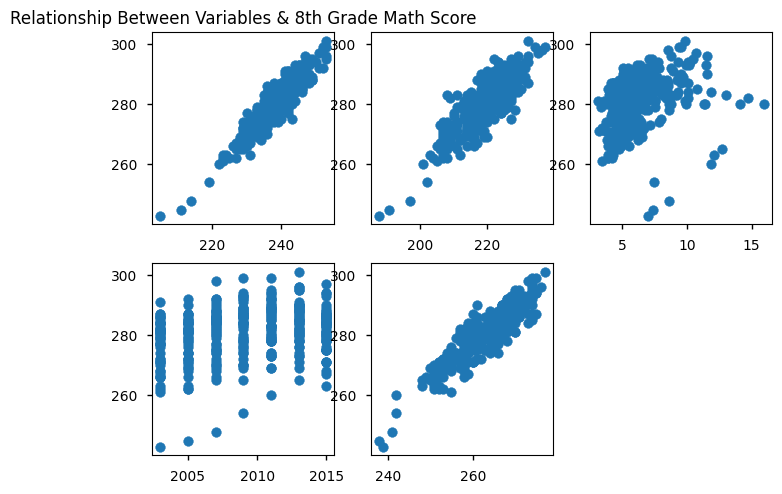

In [11]:
# Exploring why a linear regression outperforms polynomial regression.


# Filter Proper Rows
PMEXPFILTERED = Education_ByStateCleaned[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
PMEXPFILTERED = PMEXPFILTERED[pd.notna(PMEXPFILTERED['Average Math Score (4)']) & pd.notna(PMEXPFILTERED['Average Math Score (8)']) 
                                        & pd.notna(PMEXPFILTERED['Expenditure Per Student']) & pd.notna(PMEXPFILTERED['Year'])
                                        & pd.notna(PMEXPFILTERED['Average Reading Score (4)']) & pd.notna(PMEXPFILTERED['Average Reading Score (8)'])]
plt.subplot(2,3,1)
plt.scatter(PMEXPFILTERED['Average Math Score (4)'], PMEXPFILTERED['Average Math Score (8)'])
plt.title('Relationship Between Variables & 8th Grade Math Score')

plt.subplot(2,3,2)
plt.scatter(PMEXPFILTERED['Average Reading Score (4)'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplot(2,3,3)
plt.scatter(PMEXPFILTERED['Expenditure Per Student'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplot(2,3,4)
plt.scatter(PMEXPFILTERED['Year'], PMEXPFILTERED['Average Math Score (8)'])

plt.subplot(2,3,5)
plt.scatter(PMEXPFILTERED['Average Reading Score (8)'], PMEXPFILTERED['Average Math Score (8)'])

# Education



In [16]:
#Neural Network Regression
NNData = CorrelationEducation[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
NNData = NNData[pd.notna(NNData['Average Math Score (4)']) & pd.notna(NNData['Average Math Score (8)']) 
                                        & pd.notna(NNData['Expenditure Per Student']) & pd.notna(NNData['Year'])
                                        & pd.notna(NNData['Average Reading Score (4)']) & pd.notna(NNData['Average Reading Score (8)'])]
TestingFloor = math.floor(len(NNData) * .8)
NNDataDataTraining = NNData[[ 'Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[0:TestingFloor]
NNDataDataTesting = NNData[['Average Math Score (4)', 'Expenditure Per Student', 'Average Math Score (8)', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']].iloc[TestingFloor:]

XTraining = NNDataDataTraining[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTraining = NNDataDataTraining['Average Math Score (8)']

XTesting = NNDataDataTesting[['Average Math Score (4)', 'Expenditure Per Student', 'Year', 'Average Reading Score (4)', 'Average Reading Score (8)']]
YTesting = NNDataDataTesting['Average Math Score (8)']


#Filter Proper Rows
model = models.Sequential()
model.add(layers.Dense(5,activation='relu', 
					input_shape=(5,)))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(XTraining,YTraining,epochs=50)
results = model.evaluate(XTesting, YTesting)
results

Epoch 1/50
9/9 [==============================] - 1s 3ms/step - loss: 0.6974 - mean_squared_error: 0.6974
Epoch 2/50
9/9 [==============================] - 0s 3ms/step - loss: 0.6798 - mean_squared_error: 0.6798
Epoch 3/50
9/9 [==============================] - 0s 4ms/step - loss: 0.6619 - mean_squared_error: 0.6619
Epoch 4/50
9/9 [==============================] - 0s 4ms/step - loss: 0.6418 - mean_squared_error: 0.6418
Epoch 5/50
9/9 [==============================] - 0s 4ms/step - loss: 0.6205 - mean_squared_error: 0.6205
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 0.5985 - mean_squared_error: 0.5985
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5752 - mean_squared_error: 0.5752
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5518 - mean_squared_error: 0.5518
Epoch 9/50
9/9 [==============================] - 0s 3ms/step - loss: 0.5274 - mean_squared_error: 0.5274
Epoch 10/50
9/9 [=============================

[0.3176082968711853, 0.3176082968711853]